In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [4]:
DATASET_ID = 'bengalese_finch_sober'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'bf.pickle'
df_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/syllable_dfs/bengalese_finch_sober/bf.pickle')

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key,rate,spectrogram
0,1.058250,1.089219,i,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_220612_1...,32000,"[[5, 5, 5, 5, 3, 25, 26, 75, 105, 80, 47, 16, ..."
1,2.058187,2.117165,i,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_220612_1...,32000,"[[4, 4, 4, 4, 16, 8, 6, 11, 7, 3, 3, 14, 51, 2..."
2,2.234500,2.285938,i,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_220612_1...,32000,"[[2, 2, 2, 3, 0, 26, 49, 12, 9, 2, 2, 93, 68, ..."


In [9]:
len(syllable_df)

215663

In [10]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### cluster

In [11]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [14]:
ensure_dir(FIGURE_DIR / 'bf')

In [13]:
from cuml.manifold.umap import UMAP as cumlUMAP

gr41rd51 52788


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  # This is added back by InteractiveShellApp.init_path()
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  if sys.path[0] == '':


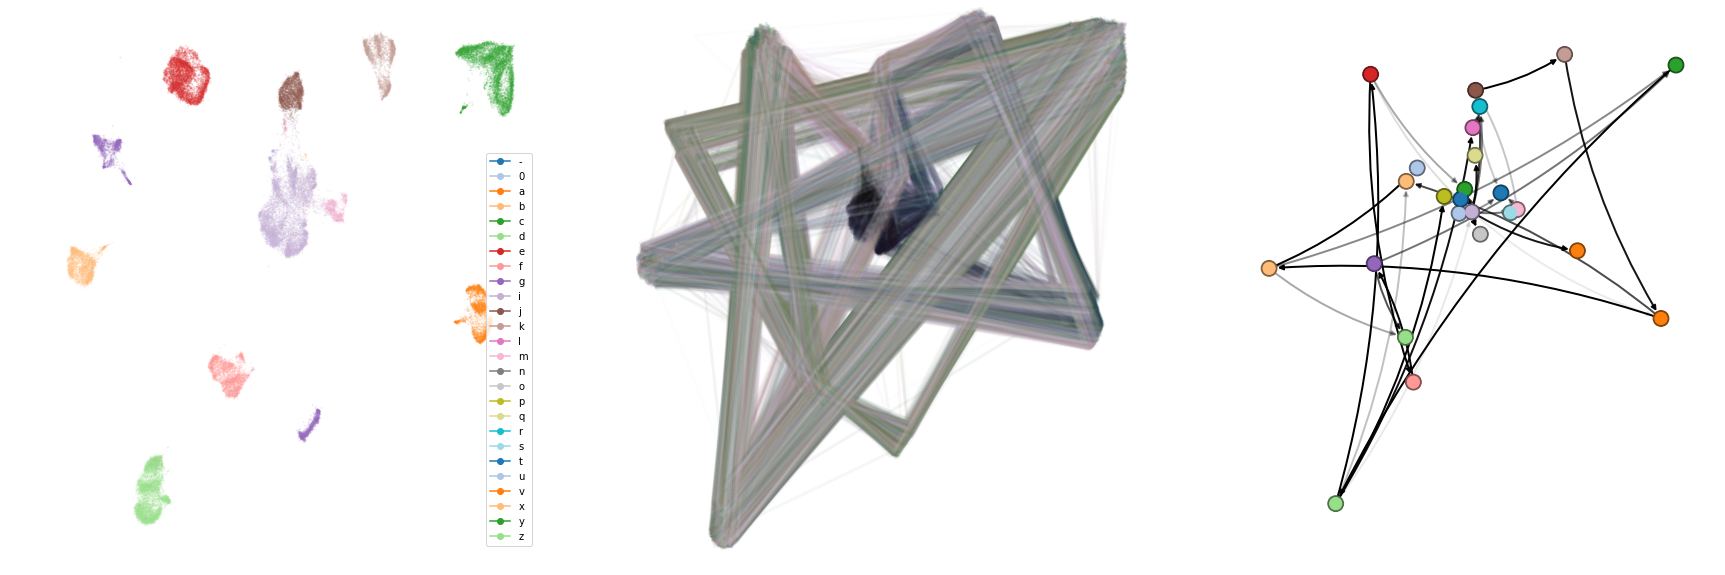

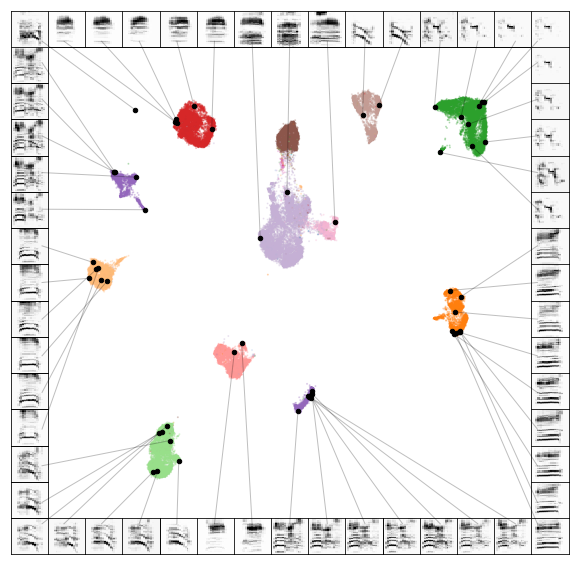

or60yw70 35799


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  # This is added back by InteractiveShellApp.init_path()
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  if sys.path[0] == '':


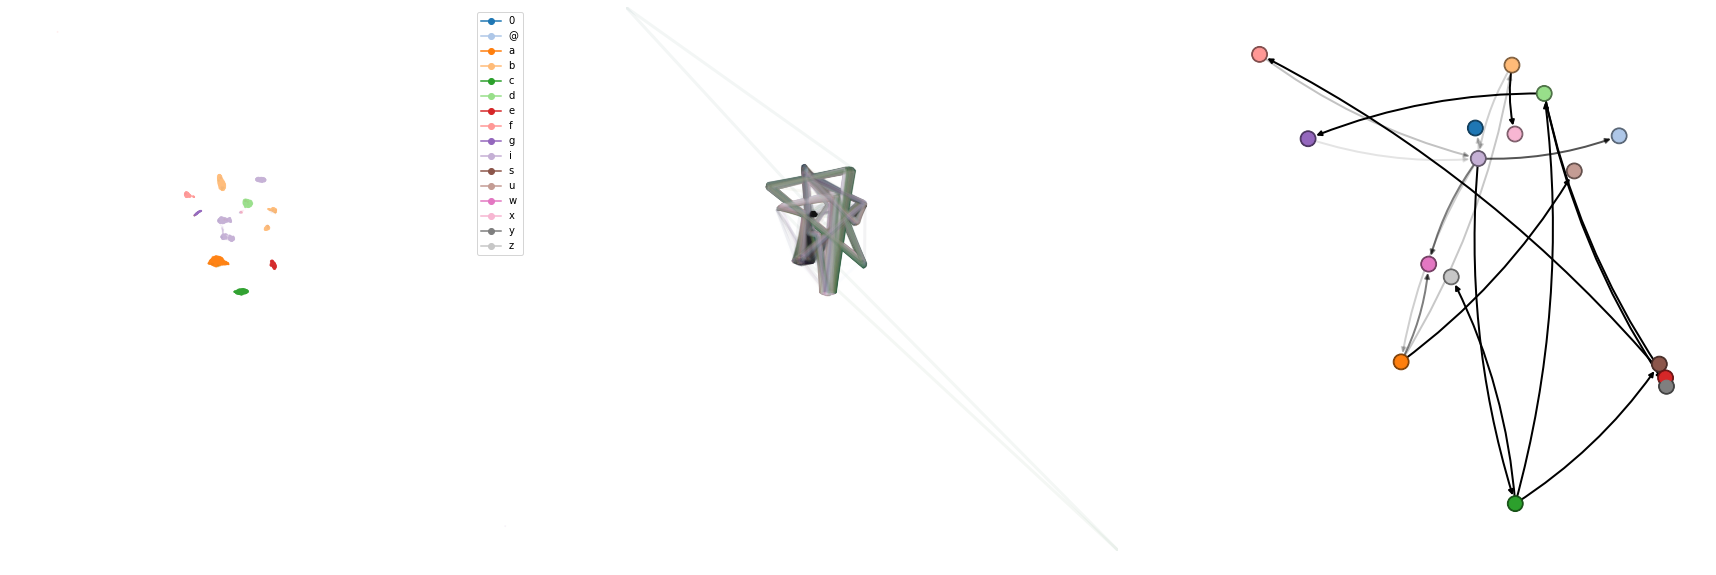

ERROR:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-cd9a6a03ea7f>", line 59, in <module>
    plt.show()
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/matplotlib/pyplot.py", line 254, in show
    return _show(*args, **kw)
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/IPython/core/display.py", line 298, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "<decorator-gen-9>", line 2,

KeyboardInterrupt: 

In [36]:
for indv in tqdm(syllable_df.indv.unique()):
    indv_df = syllable_df[syllable_df.indv == indv]
    indv_df = indv_df.sort_values(by=["key", "start_time"])
    print(indv, len(indv_df))
    #indv_df = indv_df[:20000]
    specs = list(indv_df.spectrogram.values)
    #draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)
    # umap
    specs_flattened = flatten_spectrograms(specs)
    
    cuml_umap = cumlUMAP(min_dist=0.25)
    z = list(cuml_umap.fit_transform(specs_flattened))
    #fit = umap.UMAP(min_dist=0.25)
    #z = list(fit.fit_transform(specs_flattened))
    indv_df["umap"] = z
    
    # sequencing
    indv_df["syllables_sequence_id"] = None
    indv_df["syllables_sequence_pos"] = None
    for ki, key in enumerate(indv_df.key.unique()):
        indv_df.loc[indv_df.key == key, "syllables_sequence_id"] = ki
        indv_df.loc[indv_df.key == key, "syllables_sequence_pos"] = np.arange(
            np.sum(indv_df.key == key)
        )
        
    # plot
    draw_projection_plots(indv_df, label_column="labels")
    plt.show()
    
    scatter_spec(
        np.vstack(z),
        specs,
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': list(indv_df.labels.values),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );
    

    save_fig(FIGURE_DIR / 'bf' / ('bf_sober_'+indv), dpi=300, save_jpg=True)
    plt.show()

    #break

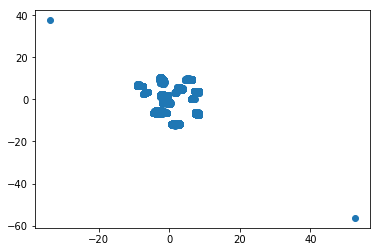

In [37]:
plt.scatter(np.array(z)[:,0], np.array(z)[:,1])

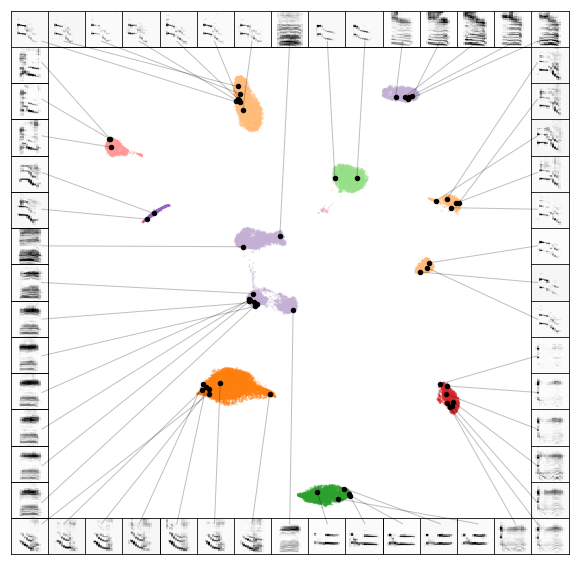

In [39]:
scatter_spec(
    np.vstack(z),
    specs,
    column_size=15,
    x_range = [-12,12],
    y_range = [-13,12],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': list(indv_df.labels.values),
        'alpha':0.25,
        's': 1,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);

save_fig(FIGURE_DIR / 'bf' / ('bf_sober_'+indv), dpi=300, save_jpg=True)
plt.show()